Notebook to analyze tropical cyclone (TC) list compiled from IBTrACS data by Frederick Tam.

TC list has already been subsetted for:
- TCs that reach at least category 3 on the SS scale
- mean shear ≤ 11 m/s

Details:  
- distance = distance at final time step when the storms were classified as TD
- "hurricane" period = time from first status as a hurricane up to first status as TS

Parent dataset: International Best Track Archive for Climate Stewardship [IBTrACS](https://www.ncei.noaa.gov/products/international-best-track-archive)


James Ruppert  
jruppert@ou.edu  
10/07/24

### Main settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tropycal import tracks, recon, utils

In [2]:
# list_path = "../storm-lists/stormlist_withMPIdistance.csv"
list_path = "../storm-lists/stormlist_withMPIdistance_v2.csv"
df = pd.read_csv(list_path)#, sep=',', on_bad_lines='skip', skiprows=4)

In [3]:
# Add a column for storm year
df['year'] = df['name'].str.extract(r'(\d{4})')
df['year'] = pd.to_numeric(df['year'])
df

,Unnamed: 0,index,name,id,mean_shear,time_before_tcg,mean_shear_hu,time_before_hu,lat,final_inten,E_MPI,distance,year
0,0,2,2000_KIROGI,"['wp052000', 'WP_05']",4.234879,24,4.734644,24,14.5333,115.0,70.014737,789.820775,2000
1,1,13,2000_SHANSHAN,"['wp262000', 'WP_26']",6.241797,60,3.094575,36,15.1500,135.0,63.411490,2970.382269,2000
2,2,19,2000_SAOMAI,"['wp222000', 'WP_22']",3.096483,24,4.882538,36,15.9900,140.0,70.234010,2224.307203,2000
3,3,24,2000_BILIS,"['wp182000', 'WP_18']",2.984449,36,3.176979,24,12.5308,140.0,77.146203,1236.925745,2000
4,4,2,2001_KROSA,"['wp242001', 'WP_24']",3.947990,24,5.985582,24,15.1077,105.0,NaN,1881.174024,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,258,9,2020_IOTA,"['al312020', 'AL_31']",5.956079,36,5.606625,36,14.0000,135.0,100.185388,321.831617,2020
259,259,16,2020_ETA,"['al292020', 'AL_29']",4.185665,12,4.129712,36,14.9000,130.0,98.657236,361.383512,2020
260,260,17,2020_LAURA,"['al132020', 'AL_13']",7.504969,36,10.385125,108,17.0000,130.0,83.262945,826.302321,2020
261,261,24,2020_TEDDY,"['al202020', 'AL_20']",9.231384,48,7.003615,48,12.9000,120.0,83.946964,1402.462279,2020


### Plots

#### Plot functions

In [4]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})

In [5]:
def add_var(figdata, ax, toggle=0):
    ax.set_title(figdata['vartag'])
    ax.set_ylabel('Count')
    ax.set_xlabel('Units = '+figdata['units'])
    sns.histplot(figdata['pltvar'], ax=ax, kde=True, bins=figdata['bins'])#, label=figdata['count'])
    default_colors = sns.color_palette()
    median = np.nanmedian(figdata['pltvar'])
    if toggle == 0:
        linestyle='-.'
    else:
        linestyle='--'
    ax.axvline(median, color=default_colors[toggle], linestyle=linestyle, label='Median = '+str(round(median, 2)))
    ax.legend()

#### Using selection critera

In [6]:
# Selection based on distance from coast
min_dfc = 500 # [km] max distance from coast
subset = df[df['distance'] >= min_dfc]

# Selection based on E-MPI
min_mpi_percentile = 33
min_empi = np.nanpercentile(df['E_MPI'], min_mpi_percentile)
print('Minimum E-MPI:', np.round(min_empi, 1))
subset = subset[subset['E_MPI'] >= min_empi]

# Selection based on E-MPI
max_shear = 11
subset = subset[subset['mean_shear_hu'] <= max_shear]

# Number of cases in original dataset
n_original = "Count = "+str(len(df))
print('Number of cases in original dataset:', n_original)
# Number of cases in selected subset
n_subset = "Count = "+str(len(subset))
print('Number of cases in selected subset:', n_subset)

Minimum E-MPI: 73.0
Number of cases in original dataset: Count = 263
Number of cases in selected subset: Count = 100


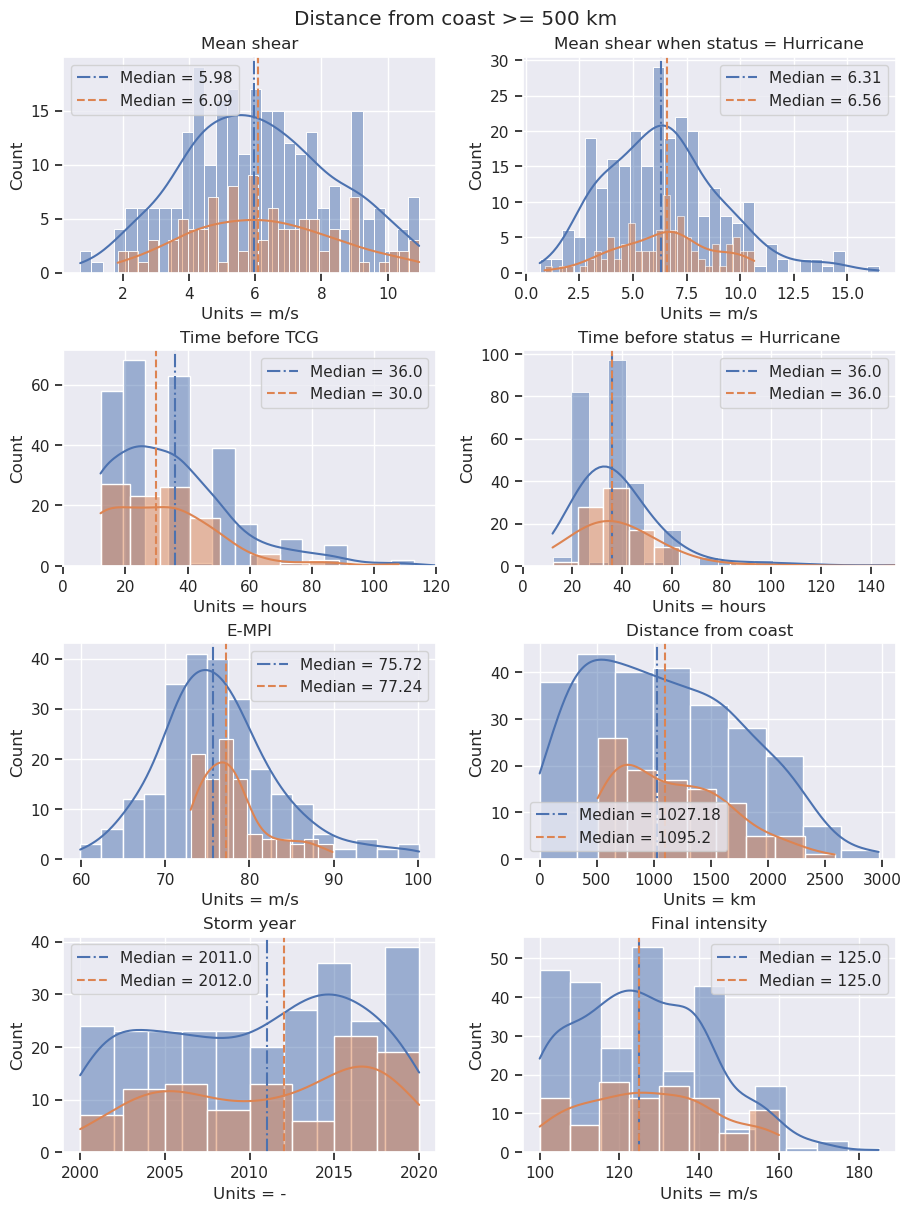

In [7]:
fig_x = 9
fig_y = 12
fig, axs = plt.subplots(4, 2, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)

plt.suptitle('Distance from coast >= '+str(min_dfc)+' km')

# for idataset in [df, subset]:
for itoggle in range(2):

    if itoggle == 0:
        idataset = df
    else:
        idataset = subset

    figdata = {
        'pltvar': idataset['mean_shear'],
        'vartag': 'Mean shear',
        'units': 'm/s',
        'bins': 30,
        'count': n_original if itoggle == 0 else n_subset,
            }

    add_var(figdata, axs[0,0], toggle=itoggle)

    ################################

    figdata = {
        'pltvar': idataset['mean_shear_hu'],
        'vartag': 'Mean shear when status = Hurricane',
        'units': 'm/s',
        'bins': 30,
        'count': n_original if itoggle == 0 else n_subset,
            }

    add_var(figdata, axs[0,1], toggle=itoggle)

    ################################

    figdata = {
        'pltvar': idataset['time_before_tcg'],
        'vartag': 'Time before TCG',
        'units': 'hours',
        'bins': 'auto',
        'count': n_original if itoggle == 0 else n_subset,
            }

    add_var(figdata, axs[1,0], toggle=itoggle)
    axs[1,0].set_xlim(0, 120)

    ################################

    figdata = {
        'pltvar': idataset['time_before_hu'],
        'vartag': 'Time before status = Hurricane',
        'units': 'hours',
        'bins': 'auto',
        'count': n_original if itoggle == 0 else n_subset,
            }

    add_var(figdata, axs[1,1], toggle=itoggle)
    axs[1,1].set_xlim(0, 150)

    ################################

    figdata = {
        'pltvar': idataset['E_MPI'],
        'vartag': 'E-MPI',
        'units': 'm/s',
        'bins': 'auto',
        'count': n_original if itoggle == 0 else n_subset,
            }

    add_var(figdata, axs[2,0], toggle=itoggle)

    ################################

    figdata = {
        'pltvar': idataset['distance'],
        'vartag': 'Distance from coast',
        'units': 'km',
        'bins': 'auto',
        'count': n_original if itoggle == 0 else n_subset,
            }

    add_var(figdata, axs[2,1], toggle=itoggle)

    ################################

    figdata = {
        'pltvar': idataset['year'],
        'vartag': 'Storm year',
        'units': '-',
        'bins': 'auto',
        'count': n_original if itoggle == 0 else n_subset,
            }

    add_var(figdata, axs[3,0], toggle=itoggle)

    ################################

    figdata = {
        'pltvar': idataset['final_inten'],
        'vartag': 'Final intensity',
        'units': 'm/s',
        'bins': 'auto',
        'count': n_original if itoggle == 0 else n_subset,
            }

    add_var(figdata, axs[3,1], toggle=itoggle)

# axs[0,1].legend()#loc='upper right')
plt.show()
plt.close()

In [8]:
subset.sort_values(by='mean_shear', ascending=True)

,Unnamed: 0,index,name,id,mean_shear,time_before_tcg,mean_shear_hu,time_before_hu,lat,final_inten,E_MPI,distance,year
108,108,6,2015_NANGKA,"['wp112015', 'WP_11']",1.847070,12,5.056706,60,9.64000,135.0,73.707341,2281.291173,2015
36,36,22,2004_MEARI,"['wp252004', 'WP_25']",2.021988,48,3.566300,48,12.72500,125.0,73.060579,1678.906630,2004
116,116,0,2016_NEPARTAK,"['wp022016', 'WP_02']",2.227425,24,6.398365,36,10.02500,155.0,77.448597,1362.745864,2016
101,101,5,2014_VONGFONG,"['wp192014', 'WP_19']",2.444245,36,7.665899,48,8.06000,155.0,78.922741,1467.928946,2014
203,203,1,2017_EUGENE,"['ep052017', 'EP_05']",2.716890,12,3.332122,36,11.60000,100.0,76.878972,1064.686982,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,120,16,2016_NOCK-TEN,"['wp302016', 'WP_30']",10.360624,36,9.745455,48,6.90667,140.0,75.307088,1004.481666,2016
46,46,12,2006_CHEBI,"['wp232006', 'WP_23']",10.410829,60,5.791017,12,15.85000,125.0,78.644531,507.735370,2006
43,43,4,2006_DURIAN,"['wp242006', 'WP_24']",10.701113,48,10.158887,60,9.97500,135.0,76.606816,1375.033390,2006
241,241,5,2009_FRED,"['al072009', 'AL_07']",10.731442,12,6.513578,24,11.70000,105.0,76.042831,581.683099,2009


In [9]:
# Print list of storms
for i, storm_subset in subset.sort_values(by='mean_shear', ascending=True).iterrows():
    print(storm_subset['name'])
# subset['name']

2015_NANGKA
2004_MEARI
2016_NEPARTAK
2014_VONGFONG
2017_EUGENE
2004_DIANMU
2000_BILIS
2009_NIDA
2018_MARIA
2019_KIKO
2019_HAGIBIS
2017_JOSE
2017_LEE
2011_NESAT
2014_NURI
2004_SONGDA
2001_ERIN
2012_EMILIA
2014_PHANFONE
2017_LAN
2004_KARL
2014_ISELLE
2000_ISAAC
2012_SANBA
2004_NOCK-TEN
2006_HELENE
2018_YUTU
2016_SEYMOUR
2002_ELIDA
2006_SAOMAI
2008_JANGMI
2011_KENNETH
2019_ERICK
2003_KETSANA
2018_ROSA
2006_DANIEL
2011_SONGDA
2002_FAUSTO
2008_FENGSHEN
2012_MIRIAM
2016_HAIMA
2011_OPHELIA
2008_RAMMASUN
2012_DANIEL
2012_JELAWAT
2006_CIMARON
2014_EDOUARD
2008_IKE
2019_FAXAI
2005_EMILY
2018_TRAMI
2012_PRAPIROON
2004_IVAN
2018_OLIVIA
2017_IRMA
2018_JEBI
2016_LESTER
2015_SANDRA
2015_JIMENA
2006_EWINIAR
2006_ILEANA
2010_CHABA
2018_NORMAN
2007_KAJIKI
2016_GASTON
2015_IN-FA
2003_FABIAN
2002_LILI
2018_LANE
2018_ALETTA
2020_LAURA
2016_DARBY
2004_SUDAL
2005_NESAT
2015_LINDA
2018_MANGKHUT
2017_FERNANDA
2015_DANNY
2018_HECTOR
2004_DARBY
2019_BUALOI
2018_CIMARON
2003_ETAU
2017_KENNETH
2006_UTOR
2003_KUJIR

#### Map of TCs

In [10]:
# Get storm tracks

storm_names = df['name']
years = storm_names.apply(lambda x: x[0:4] if isinstance(x, str) else x)
storm_names = storm_names.apply(lambda x: x[5:] if isinstance(x, str) else x)
storm_ids = df['id'].apply(lambda x: x[2:10])

basin = tracks.TrackDataset(source='ibtracs', basin='all')

subset_lon = []
subset_lat = []
for istorm in storm_ids:#[0:3]:
    storm = basin.get_storm(istorm.upper())
    subset_lon.append(storm.vars['lon'])
    subset_lat.append(storm.vars['lat'])

--> Starting to read in ibtracs data


--> Completed reading in ibtracs data (86.6 seconds)


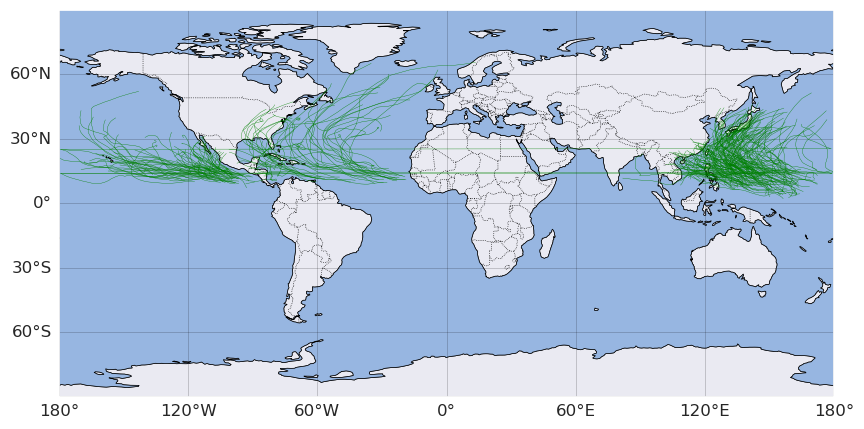

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

plt_area=[-180, 180, -90, 90]
# plt_area=[-180, 180, -45, 45]
ax.set_extent(plt_area, crs=ccrs.PlateCarree())

# Add coastlines and borders
featurewidth=0.5
# ax.coastlines(linewidth=featurewidth)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=featurewidth)#, facecolor='none')

# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='black', linewidth=featurewidth, alpha=0.25)#, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add additional features if needed
ax.add_feature(cfeature.LAND, edgecolor='black', linewidth=featurewidth, facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', linewidth=featurewidth)#, facecolor='none')
# ax.add_feature(cfeature.LAKES, alpha=0.5, edgecolor='black', linewidth=featurewidth, facecolor='none')
# ax.add_feature(cfeature.RIVERS, edgecolor='black', linewidth=featurewidth, facecolor='none')

for istorm in range(len(subset_lon)):
    # ax.plot(lon, lat, marker='o', color='red', markersize=5, transform=ccrs.PlateCarree())
    ax.plot(subset_lon[istorm], subset_lat[istorm], color='green', transform=ccrs.PlateCarree(), linewidth=0.25)

# plt.savefig(figdir+plot_name+"_"+hr_tag[0:-3]+".pdf", format="pdf", bbox_inches="tight")
plt.show()
plt.close()